<a href="https://colab.research.google.com/github/MegaJoctan/ONNX-MQL5/blob/main/onnx_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Basic Imports

In [ ]:
import pandas as pd
import numpy as np
import os

### Global Parameters

In [ ]:
csv_file = "EURUSD-OHLSignalPCA.csv"
step_size = 7
inp_model_name = "model.eurusd.D1.PCA.onnx"

### Prepare Sequential data


In [ ]:
def get_sequential_data(data, time_step):
    if dataset.empty is True:
      print("Failed to create sequences from an empty dataset")
      return

    Y = data.iloc[:, -1].to_numpy() # get the last column from the dataset and assign it to y numpy 1D array
    X = data.iloc[:, :-1].to_numpy() # Get all the columns from data array except the last column, assign them to x numpy 2D array

    X_reshaped = []
    Y_reshaped = []

    for i in range(len(Y) - time_step + 1):
        X_reshaped.append(X[i:i + time_step])
        Y_reshaped.append(Y[i + time_step - 1])

    return np.array(X_reshaped), np.array(Y_reshaped)

In [ ]:
!pip install tf2onnx

### Necessary imports for timeseries models


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Dropout, Flatten, LSTM
from keras.metrics import RootMeanSquaredError as rmse
import tf2onnx

### Get the data and extract target column classes

In [ ]:
dataset = pd.read_csv(csv_file)

y = []
if not dataset.empty:
   y = dataset.iloc[:, -1].to_numpy()

classes_in_data = np.unique(y)

print("OHLC DATASET\n",dataset.head(),"\nClasses",classes_in_data)

OHLC DATASET
        None    None.1  None.2
0  0.780465 -0.503271     0.0
1  0.721395  0.799352     0.0
2  0.689822 -0.849680     1.0
3  0.705495 -0.781124     1.0
4  0.716198 -0.535190     1.0 
Classes [0. 1.]


### Define LSTM model

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

learning_rate = 1e-3
patience = 5 #if this number of epochs validation loss is unchanged stop the process


model = Sequential()

model.add(LSTM(units=10, input_shape=(step_size, dataset.shape[1]-1))) #Input layer
model.add(Dense(units=10, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(units=len(classes_in_data), activation = 'softmax')) #last layer outputs = classes in data

model.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=['accuracy'])

### Model Summary

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                520       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 22        
                                                                 
Total params: 652 (2.55 KB)
Trainable params: 652 (2.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Getting sequential data & Train-test split

In [ ]:
X_reshaped, Y_reshaped = get_sequential_data(dataset, step_size)

x_train, x_test, y_train, y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.3, random_state=42)  # Example with a random_state

print(f"x_train{x_train.shape} y_train{y_train.shape}\nx_test{x_test.shape} y_test{y_test.shape}")

x_train(6995, 7, 2) y_train(6995,)
x_test(2999, 7, 2) y_test(2999,)


### Train the model for 100 epochs

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=len(classes_in_data)) #ONE-HOT encoding
y_test = to_categorical(y_test, num_classes=len(classes_in_data)) #ONE-HOT encoding

early_stopping = EarlyStopping(monitor='val_loss', patience = patience, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs = 100 , validation_data = (x_test,y_test), callbacks=[early_stopping], batch_size=64, verbose=2)

Epoch 1/100
110/110 - 3s - loss: 0.6940 - accuracy: 0.5131 - val_loss: 0.6926 - val_accuracy: 0.5135 - 3s/epoch - 30ms/step
Epoch 2/100
110/110 - 1s - loss: 0.6933 - accuracy: 0.5108 - val_loss: 0.6926 - val_accuracy: 0.5045 - 542ms/epoch - 5ms/step
Epoch 3/100
110/110 - 1s - loss: 0.6927 - accuracy: 0.5194 - val_loss: 0.6927 - val_accuracy: 0.5105 - 621ms/epoch - 6ms/step
Epoch 4/100
110/110 - 1s - loss: 0.6930 - accuracy: 0.5134 - val_loss: 0.6925 - val_accuracy: 0.5048 - 615ms/epoch - 6ms/step
Epoch 5/100
110/110 - 1s - loss: 0.6929 - accuracy: 0.5071 - val_loss: 0.6925 - val_accuracy: 0.5038 - 622ms/epoch - 6ms/step
Epoch 6/100
110/110 - 1s - loss: 0.6927 - accuracy: 0.5107 - val_loss: 0.6925 - val_accuracy: 0.5038 - 590ms/epoch - 5ms/step
Epoch 7/100
110/110 - 1s - loss: 0.6927 - accuracy: 0.5128 - val_loss: 0.6925 - val_accuracy: 0.5062 - 627ms/epoch - 6ms/step
Epoch 8/100
110/110 - 1s - loss: 0.6924 - accuracy: 0.5155 - val_loss: 0.6922 - val_accuracy: 0.5118 - 627ms/epoch - 6ms

### Show iteration-loss graph for training and validation

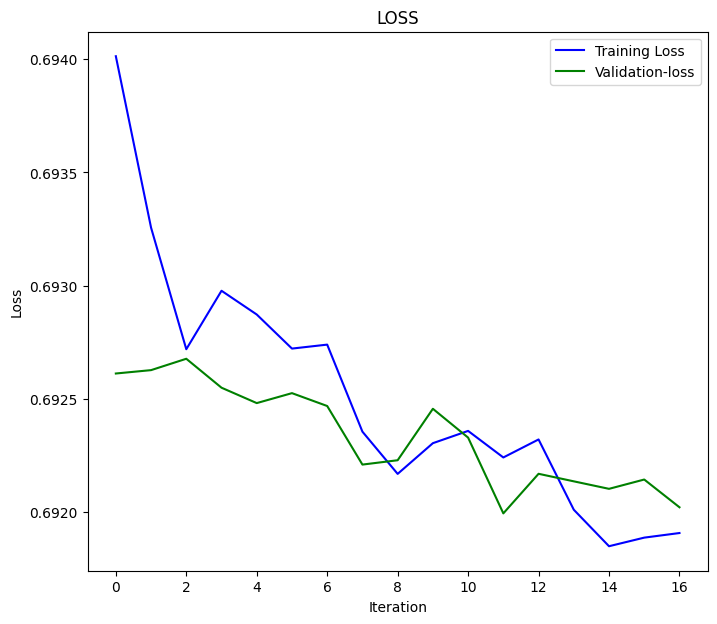

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,7))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("LOSS")
plt.legend()

### Saving LSTM model in ONNX format

In [ ]:
output_path = inp_model_name
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"saved model to {output_path}")

saved model to model.eurusd.D1.PCA.onnx


### Let's test the model on the data it was trained on

In [ ]:
X_reshaped, Y_reshaped = get_sequential_data(dataset, step_size)

print(f"x_shape{X_reshaped.shape} y_shape{Y_reshaped.shape}")

predictions = model.predict(X_reshaped)

predictions = classes_in_data[np.argmax(predictions, axis=1)]  # Find class with highest probability  | converting predicted probabilities to classes

print("predictions:\n",predictions)

#for pred in predictions:
# print(f"[{pred}]")

from sklearn.metrics import accuracy_score

print("LSTM model accuracy: ", accuracy_score(Y_reshaped, predictions))


x_shape(9994, 7, 2) y_shape(9994,)
313/313 [==============================] - 1s 2ms/step
predictions:
 [0. 0. 0. ... 0. 0. 0.]
LSTM model accuracy:  0.5240144086451871
